In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#data preparation
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#regression models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

#evaluation
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv(  		  	   		  		 			  		 			     			  	 
        "Alien Data Set.csv",  )  	
print(df.info())
# print(df.head())
# print(df["Age"].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex                3893 non-null   object 
 1   Length             3893 non-null   float64
 2   Diameter           3893 non-null   float64
 3   Height             3893 non-null   float64
 4   Shell Mass         3893 non-null   float64
 5   Visceral Fat Mass  3893 non-null   float64
 6   Body Fat Mass      3893 non-null   float64
 7   Age                3893 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 243.4+ KB
None


Check why there are values of age less than 0. It seems not a data mistake, as the other data entries look normal. Maybe alien age starts from -1.

Text(0.5, 1.0, 'alen age distribution')

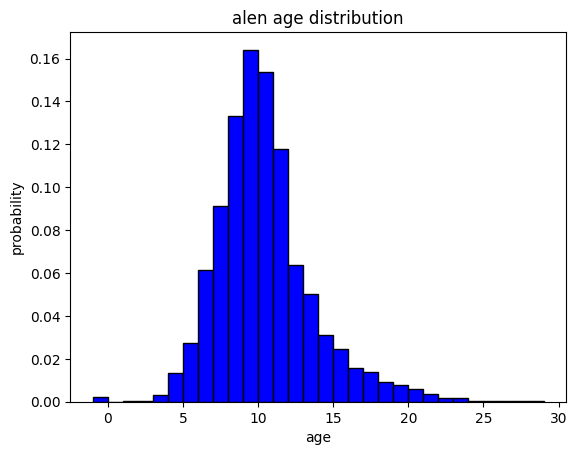

In [3]:
df['Age'].value_counts(normalize=True)
df_negative_age = df[df['Age']<0]
df_negative_age

# trying to add another total mass column
# df["total mass"]= df["Shell Mass"]+df["Visceral Fat Mass"]+df["Body Fat Mass"]


# see how it affects the performance by dropping some columns
# df = df.drop(columns=["Body Fat Mass"])

plt.hist(df['Age'], bins=30, color='blue', edgecolor='black',density=True)
plt.xlabel('age')
plt.ylabel('probability')
plt.title('alen age distribution')



##### data transformation

In [4]:
X=df.drop(columns=['Age'],axis=1)
y = df['Age'].astype(float)

num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

num_pipeline= Pipeline(
    steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
    ]
)
cat_pipeline=Pipeline(
    steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder",OneHotEncoder()),
    ("scaler",StandardScaler(with_mean=False))
    ]
)
preprocessor=ColumnTransformer(
    [
    ("num_pipeline",num_pipeline,num_features),
    ("cat_pipelines",cat_pipeline,cat_features)
    ]
)

X = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

##### select 5 regression models and compare their performances, only the best will be used

In [5]:

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(), 
    "Support Vector": SVR(),
}


def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    return mae

model_list = []
mae_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_accuracy  = evaluate_model(y_train, y_train_pred)

    model_test_accuracy = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    print('Model performance for Training set')
    print("- accuracy: {:.4f}".format(model_train_accuracy))

    print('----------------------------------')
    
    print('Model performance for Testing set')
    print("- accuracy: {:.4f}".format(model_test_accuracy))

    model_list.append(model)
    mae_list.append(model_test_accuracy)
    
    print('='*35)



Linear Regression
Model performance for Training set
- accuracy: 1.6294
----------------------------------
Model performance for Testing set
- accuracy: 1.5822
Decision Tree
Model performance for Training set
- accuracy: 0.0000
----------------------------------
Model performance for Testing set
- accuracy: 2.1374


Random Forest
Model performance for Training set
- accuracy: 0.6083
----------------------------------
Model performance for Testing set
- accuracy: 1.6140
Gradient Boosting
Model performance for Training set
- accuracy: 1.6046
----------------------------------
Model performance for Testing set
- accuracy: 1.6835
Support Vector
Model performance for Training set
- accuracy: 1.7811
----------------------------------
Model performance for Testing set
- accuracy: 1.6793


##### best model is linear regression

0.2246469833119384
0.4441591784338896
0.7252888318356868
0.8716302952503209


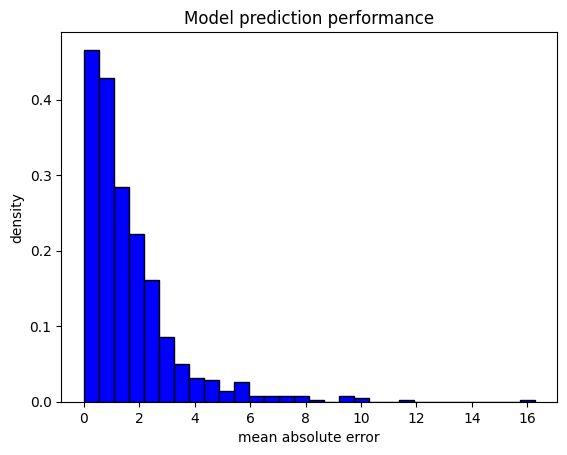

In [6]:
best_model= model_list[-3]
error = abs(best_model.predict(X_test)-y_test)

plt.hist(error, bins=30, color='blue', edgecolor='black',density=True)
plt.xlabel('mean absolute error')
plt.ylabel('density')
plt.title('Model prediction performance')
n=len(error)

print(len(error[error<0.5])/n)
print(len(error[error<1])/n)
print(len(error[error<2])/n)
print(len(error[error<3])/n)

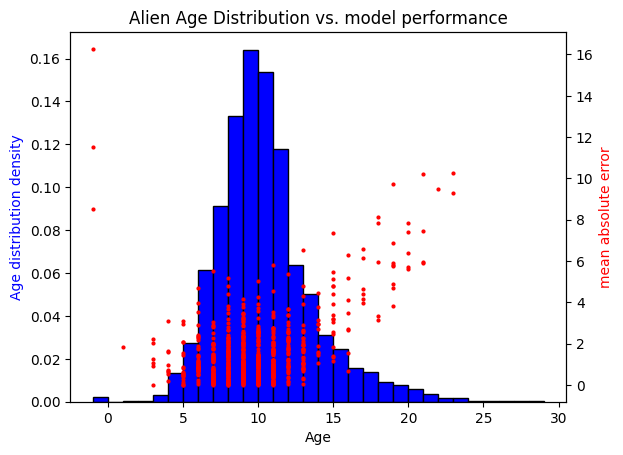

In [7]:
fig, ax1 = plt.subplots()

# Plot the histogram on the primary axis
ax1.hist(df['Age'], bins=30, color='blue', edgecolor='black', density=True)
ax1.set_xlabel('Age')
ax1.set_ylabel('Age distribution density', color='blue')
ax1.set_title('Alien Age Distribution vs. model performance')

# Create secondary axis
ax2 = ax1.twinx()

# Plot the scatter plot on the secondary axis
ax2.scatter(y_test, error, color='red', label='Accuracy',s=4)
ax2.set_ylabel('mean absolute error', color='red')

# Show the plot
plt.show()


#### Summary
- Out of 5 regression models tested, linear regression works best for this alien age prediction

- There are a total of 3893 data entries. 779 are randomly choosen for testing and the rest for training. Out of the 779 test cases 
    - about 25% the prediction has error less than 0.5 year 
    - about 50% the prediction has error less than 1 year 
    - about 75% the prediction has error less than 2 year 
    - about 85% the prediction has error less than 3 year 

- The prediction error is affected by the data distribution. Most of aliens in the dataset is between 5 and 15 years old. The model performance deterioates outside this range.

- What could be improved
    - More data for ages > 15 can definitly improve the overall performance of the model
    - Random forest might slightly outperforms linear regresssion for ages > 15. Maybe an ensemble model could be helpful for predicting ages outside the normal range.  



- Other
    - Since "Sex" column has three values, I've tried to remove "Indeterminant" data to see if that has any effect on the model. Results show that removing data with "Indeterminant" deterioriates the model performance. This is expected since age is likely not directly correlated to ages.
    - Data manipulation. There are 3 columns related to mass. I tried an additional column that calcualtes the total mass, but this does not improves the model.
    - Some aliens are -1 year old. This seems not like a mistake as the other data entries look normal. 
